In [140]:
#From: https://stackoverflow.com/a/28073228/758157
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show/hide code blocks."></form>''')

In [141]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.style.use('ggplot')

import pandas as pd
import numpy as np

In [142]:
from src.db import pii_eng

### Summary

In [143]:
total_pii_records = pii_eng.execute('SELECT COUNT(*) records FROM sirad_id').fetchone()[0]
records_with_valid_sirad_id = pii_eng.execute('SELECT COUNT(*) FROM sirad_id WHERE sirad_id <> 0').fetchone()[0]
unique_sirad_ids = pii_eng.execute('SELECT COUNT(DISTINCT sirad_id) FROM sirad_id WHERE sirad_id <> 0').fetchone()[0]
unique_sirad_ids_with_valid_ssn = pii_eng.execute('SELECT COUNT(*) FROM (SELECT MIN(valid_ssn) valid_ssn FROM sirad_id GROUP BY sirad_id) WHERE valid_ssn = 0').fetchone()[0]
q = """
SELECT SUM(records)
FROM (
    SELECT sirad_id, 
           COUNT(*) AS records,
           CASE WHEN MIN(valid_ssn) = 0 THEN 1 ELSE 0 END valid_ssn
    FROM sirad_id
    GROUP BY sirad_id
)
WHERE VALID_SSN = 1
GROUP BY VALID_SSN
"""
recs_with_valid_ssn = pii_eng.execute(q).fetchone()[0]

In [144]:
msg = """
PII records: {total_pii}
Records with valid SIRAD_ID: {valid_sirad}
Unique SIRAD_IDs: {uniq_sirad}
Unique SIRAD_IDs with a valid SSN associated: {valid_ssn}
Total records with valid SSN attached: {total_valid_ssn}
""".format(
    total_pii=total_pii_records, 
    valid_sirad=records_with_valid_sirad_id,
    uniq_sirad=unique_sirad_ids,
    valid_ssn=unique_sirad_ids_with_valid_ssn,
    total_valid_ssn=recs_with_valid_ssn
)
print(msg)


PII records: 1580
Records with valid SIRAD_ID: 1574
Unique SIRAD_IDs: 1383
Unique SIRAD_IDs with a valid SSN associated: 642
Total records with valid SSN attached: 642



### Dataset breakdown

In [145]:
q = """
SELECT dsn AS dataset, 
       count(*) AS records,
       SUM(CASE WHEN SIRAD_ID <> 0 THEN 1 ELSE 0 END) sirad_ids,
       SUM(CASE WHEN valid_ssn = 0 THEN 1 ELSE 0 END) valid_ssn,
       SUM(CASE WHEN valid_ssn = 1 AND ssn IS NOT NULL THEN 1 ELSE 0 END) invalid_ssn,
       SUM(CASE WHEN valid_ssn = 2 THEN 1 ELSE 0 END) questionable_ssn,
       SUM(CASE WHEN ssn IS null THEN 1 ELSE 0 END) missing_ssn,
       SUM(CASE WHEN first_name IS NOT null THEN 1 ELSE 0 END) first_name,
       SUM(CASE WHEN last_name IS NOT null THEN 1 ELSE 0 END) last_name,
       SUM(CASE WHEN dob is NOT null THEN 1 ELSE 0 END) dob
from sirad_id
group by dsn
"""
dataset_breakdown = pd.read_sql(q, con=pii_eng, index_col='dataset')

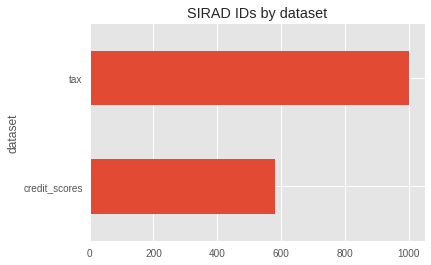

In [146]:
dataset_breakdown['records'].plot(kind="barh", title="SIRAD IDs by dataset");

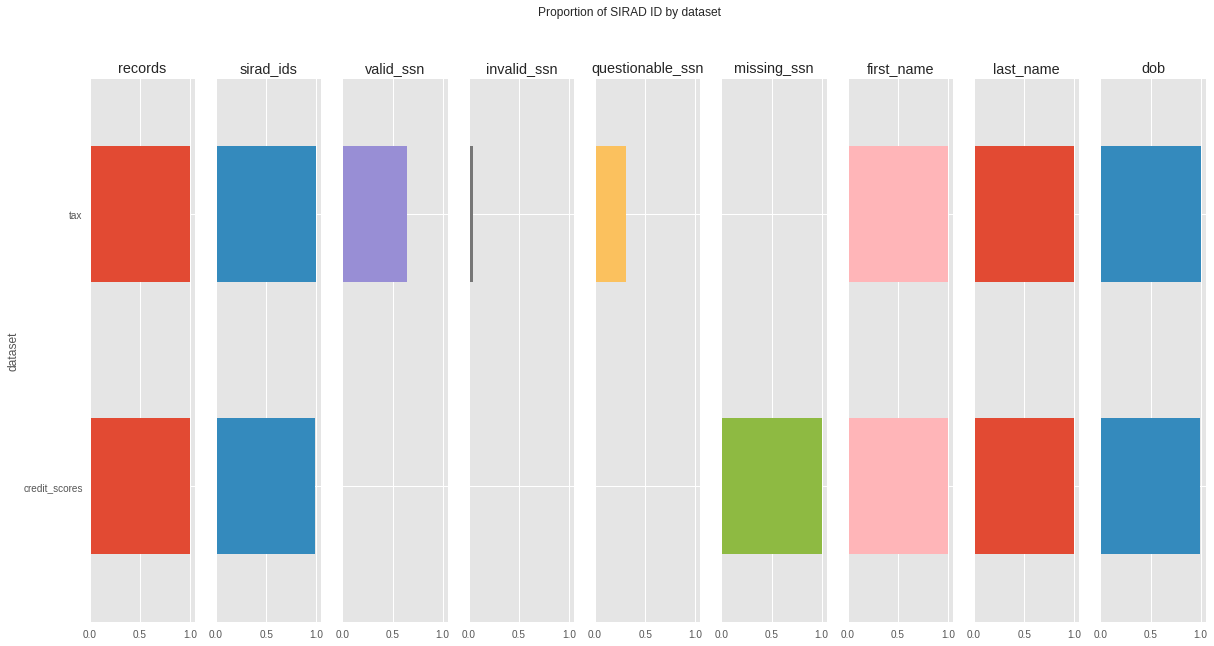

In [147]:
dataset_breakdown_pct = dataset_breakdown.apply(lambda x: x / x['records'], axis=1)
dataset_breakdown_pct.plot(
    kind="barh",
    subplots=True,
    layout=(1,9),
    sharey=True,
    legend=False,
    figsize=(20, 10),
    title="Proportion of SIRAD ID by dataset"
);

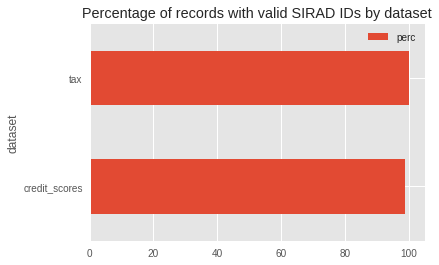

In [148]:
q = """
WITH t AS
(
SELECt dsn, COUNT(*) as records
FROM sirad_id
GROUP BY dsn
), SID as (
SELECT dsn, COUNT(*) AS records_with_sid
FROM sirad_id
WHERE sirad_id <> 0
GROUP BY dsn
)
SELECT dsn as dataset, (CAST(records_with_sid AS FLOAT) / records) * 100 as perc
FROM t
JOIN sid USING(dsn) 
"""
dsn_perc = pd.read_sql(q, con=pii_eng, index_col='dataset')
dsn_perc.plot(kind="barh", title="Percentage of records with valid SIRAD IDs by dataset");

### Birth year histogram

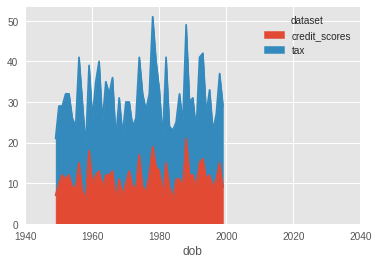

In [149]:
q = """
SELECT dsn AS dataset, CAST(STRFTIME('%Y', dob) AS INT) dob, COUNT(*) AS records
FROM sirad_id
GROUP BY DSN, STRFTIME('%Y', dob) ;
"""
dob_df = pd.read_sql(q, con=pii_eng)
pivoted_dob = dob_df.pivot(index='dob', columns='dataset', values='records')
pivoted_dob = pivoted_dob[pd.Series(index=pivoted_dob.index, data=np.isfinite(pivoted_dob.index))]
pivoted_dob.fillna(0, inplace=True)
pivoted_dob[1:].plot(kind='area', xlim=[1940, 2040]);

### Missing data

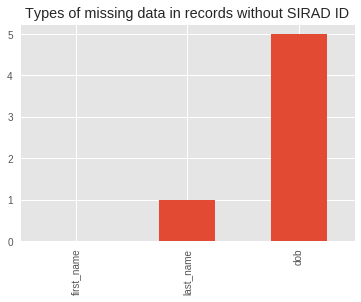

In [153]:
q = """
select 
  sum(case when first_name is null then 1 else 0 end) first_name,
  sum(case when last_name is null then 1 else 0 end) last_name,
  sum(case when dob is null then 1 else 0 end) dob
from sirad_id
where sirad_id=0
"""
missing_df = pd.read_sql(q, con=pii_eng)
missing_series = missing_df.loc[0]
missing_series.plot(kind="bar", title="Types of missing data in records without SIRAD ID");

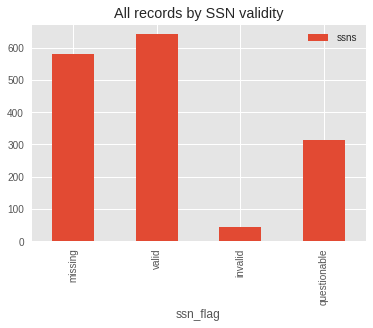

In [169]:
q = """
SELECT 
  CASE WHEN valid_ssn IS null THEN "missing"
  WHEN valid_ssn IS 1 THEN "invalid"
  WHEN valid_ssn IS 2 THEN "questionable"
  WHEN valid_ssn IS 0 THEN "valid"
  END as ssn_flag, count(*) as ssns
FROM sirad_id
GROUP BY valid_ssn
"""
ssn_v = pd.read_sql(q, con=pii_eng, index_col="ssn_flag")
ssn_v.plot(kind="bar", title="All records by SSN validity")